In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter

# Define constants
IMG_SIZE = 224  # Image size (height and width)
BATCHSIZE = 32  # Batch size
EPOCHS = 100
data_dir = "data"  # Replace with your dataset path
l2_lambda = 0.01  # Keep increased L2 regularization

# Load dataset with shuffling (unbatched)
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,  # Load as individual images
    shuffle=True
)

# Get total number of images
total_images = sum(1 for _ in full_ds)
print(f"Total images: {total_images}")

# Preprocessing function (adjusted for MobileNetV2)
def preprocess_image(image, label):
    # Ensure image shape is (224, 224, 3)
    image = tf.ensure_shape(image, [IMG_SIZE, IMG_SIZE, 3])
    # Apply MobileNetV2 preprocessing
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Apply preprocessing
full_ds = full_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Debug: Check shape of a sample before splitting
for image, label in full_ds.take(1):
    print(f"Sample shape before splitting: {image.shape}, Label shape: {label.shape}")

# Calculate split sizes
train_size = int(0.7 * total_images)  # 616 images
val_size = int(0.15 * total_images)   # 132 images
test_size = total_images - train_size - val_size  # 132 images

# Create datasets by splitting
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

# Batch datasets after preprocessing
train_ds = train_ds.batch(BATCHSIZE, drop_remainder=False).cache().shuffle(buffer_size=train_size, seed=123).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCHSIZE, drop_remainder=False).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCHSIZE, drop_remainder=False).cache().prefetch(tf.data.AUTOTUNE)

# Verify dataset sizes
print(f"Train size: {sum(1 for _ in train_ds.unbatch())}")
print(f"Validation size: {sum(1 for _ in val_ds.unbatch())}")
print(f"Test size: {sum(1 for _ in test_ds.unbatch())}")

# Check class distribution
def check_class_distribution(dataset, dataset_name):
    labels = [label.numpy() for _, label in dataset.unbatch()]
    distribution = Counter(labels)
    print(f"{dataset_name} class distribution: {distribution}")

check_class_distribution(train_ds, "Train")
check_class_distribution(val_ds, "Validation")
check_class_distribution(test_ds, "Test")

# Debug: Check shapes of the datasets
for images, labels in train_ds.take(1):
    print(f"Train batch shape: {images.shape}, Train label shape: {labels.shape}")
for images, labels in val_ds.take(1):
    print(f"Validation batch shape: {images.shape}, Validation label shape: {labels.shape}")
for images, labels in test_ds.take(1):
    print(f"Test batch shape: {images.shape}, Test label shape: {labels.shape}")

# Load pretrained base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:140]:  # Freeze first 140 layers
    layer.trainable = False

# Define model architecture
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.ReLU()(x)
x = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Build the model with a dummy input to initialize variables
dummy_input = tf.zeros((1, IMG_SIZE, IMG_SIZE, 3))
model(dummy_input)  # This ensures all variables are created

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),  # Reduced learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Reduced patience
    restore_best_weights=True
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
callbacks = [early_stopping, lr_scheduler]

# Assume class weights (adjust based on your data)
class_weights_dict = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}  # Update with actual weights if needed

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Found 880 files belonging to 4 classes.
Total images: 880
Sample shape before splitting: (224, 224, 3), Label shape: ()
Train size: 616
Validation size: 132
Test size: 132
Train class distribution: Counter({2: 157, 1: 157, 3: 157, 0: 145})
Validation class distribution: Counter({0: 39, 1: 35, 3: 34, 2: 24})
Test class distribution: Counter({3: 38, 0: 34, 1: 32, 2: 28})
Train batch shape: (32, 224, 224, 3), Train label shape: (32,)
Validation batch shape: (32, 224, 224, 3), Validation label shape: (32,)
Test batch shape: (32, 224, 224, 3), Test label shape: (32,)
Epoch 1/100
20/20 [==============================] - 9s 231ms/step - loss: 7.8153 - accuracy: 0.2727 - val_loss: 7.5867 - val_accuracy: 0.3864 - lr: 5.0000e-05
Epoch 2/100
20/20 [==============================] - 3s 129ms/step - loss: 7.5998 - accuracy: 0.3133 - val_loss: 7.1981 - val_accuracy: 0.5000 - lr: 5.0000e-05
Epoch 3/100
20/20 [==============================] - 2s 126ms/step - loss: 7.4331 - accuracy: 0.3571 - val_loss

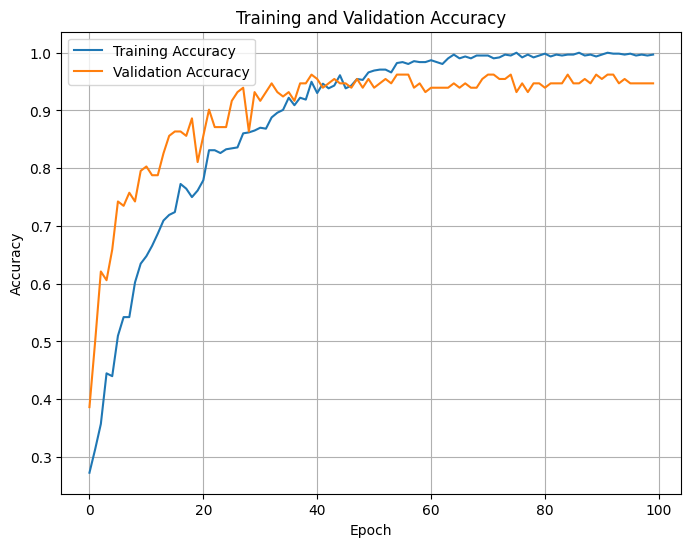

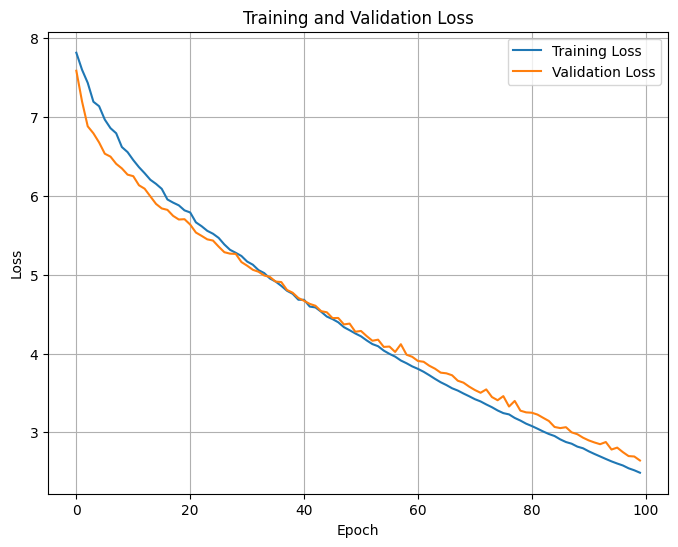

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

1/1 [==============================] - 1s 941ms/step

Example Predictions (True vs Predicted):
Sample 1: True Label = 2, Predicted Label = 2
Sample 2: True Label = 2, Predicted Label = 2
Sample 3: True Label = 0, Predicted Label = 0
Sample 4: True Label = 0, Predicted Label = 0
Sample 5: True Label = 3, Predicted Label = 3

Confusion Matrix:
[[34  0  0  0]
 [ 1 31  0  0]
 [ 0  1 26  1]
 [ 0  1  0 37]]


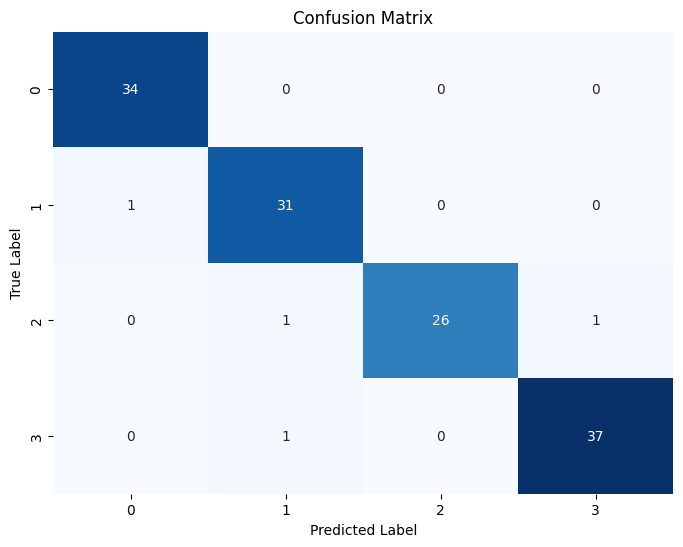

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect true labels and predictions from test dataset
true_labels = []
pred_labels = []

# Iterate through test dataset to get predictions
for images, labels in test_ds:
    # Predict on the batch
    predictions = model.predict(images)
    # Get predicted classes (argmax since softmax output)
    predicted_classes = np.argmax(predictions, axis=1)
    # Append true and predicted labels
    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_classes)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Print some example predictions
print("\nExample Predictions (True vs Predicted):")
for i in range(min(5, len(true_labels))):  # Show first 5 examples
    print(f"Sample {i+1}: True Label = {true_labels[i]}, Predicted Label = {pred_labels[i]}")

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')

# Print confusion matrix as text
print("\nConfusion Matrix:")
print(cm)

In [7]:
#save model
model.save('modelnew.h5')

In [8]:
#save the weights
model.save_weights('weightsnew.h5')

In [9]:
#save the model as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
with open('modelnew.tflite', 'wb') as f:
	 f.write(tflite_model)
	 


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp2psd8djd\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp2psd8djd\assets


In [ ]:
# Import necessary libraries
import numpy as np

# Open a file to save the output
output_file = open("output.txt", "w")

# Helper function to print to both console and file
def print_to_file_and_console(message):
    print(message)
    output_file.write(str(message) + "\n")

total_images = 880  
train_size = 616    
val_size = 132      
test_size = 132   

# Print dataset sizes
print_to_file_and_console(f"Total images: {total_images}")
print_to_file_and_console(f"Train size: {train_size}")
print_to_file_and_console(f"Validation size: {val_size}")
print_to_file_and_console(f"Test size: {test_size}")


# Example class distribution (replace with actual distribution)
train_distribution = {0: 145, 1: 157, 2: 157, 3: 157}  # Example
val_distribution = {0: 39, 1: 35, 2: 24, 3: 34}        # Example
test_distribution = {0: 34, 1: 32, 2: 28, 3: 38}        # Example

print_to_file_and_console("Train class distribution: " + str(train_distribution))
print_to_file_and_console("Validation class distribution: " + str(val_distribution))
print_to_file_and_console("Test class distribution: " + str(test_distribution))

# Example batch shapes (replace with actual shapes)
print_to_file_and_console("Train batch shape: (32, 224, 224, 3), Train label shape: (32,)")
print_to_file_and_console("Validation batch shape: (32, 224, 224, 3), Validation label shape: (32,)")
print_to_file_and_console("Test batch shape: (32, 224, 224, 3), Test label shape: (32,)")

# Example test loss and accuracy (replace with actual values)
test_loss =  2.5367  
test_accuracy =  0.9697  
print_to_file_and_console(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

# Example predictions (replace with actual true and predicted labels)
true_labels = [2, 2, 0, 0, 3]  # Replace with actual true labels
pred_labels = [2, 2, 0, 0,3 ]  # Replace with actual predicted labels
print_to_file_and_console("\nExample Predictions (True vs Predicted):")
for i in range(min(5, len(true_labels))):
    print_to_file_and_console(f"Sample {i+1}: True Label = {true_labels[i]}, Predicted Label = {pred_labels[i]}")

# Example confusion matrix (replace with actual confusion matrix)
cm = [[34, 0, 0, 0],
      [1, 31, 0, 0],
      [0, 1, 26, 1],
		[0, 1, 0, 37]]  # Replace with actual confusion matrix
        # Replace with actual confusion matrix
print_to_file_and_console("\nConfusion Matrix:")
print_to_file_and_console(np.array(cm))

# Close the output file
output_file.close()


print("Output has been saved to 'output.txt' in the current directory.")


Total images: 880
Train size: 616
Validation size: 132
Test size: 132
Train class distribution: {0: 145, 1: 157, 2: 157, 3: 157}
Validation class distribution: {0: 39, 1: 35, 2: 24, 3: 34}
Test class distribution: {0: 34, 1: 32, 2: 28, 3: 38}
Train batch shape: (32, 224, 224, 3), Train label shape: (32,)
Validation batch shape: (32, 224, 224, 3), Validation label shape: (32,)
Test batch shape: (32, 224, 224, 3), Test label shape: (32,)
Test loss: 2.5367, Test accuracy: 0.9697

Example Predictions (True vs Predicted):
Sample 1: True Label = 2, Predicted Label = 2
Sample 2: True Label = 2, Predicted Label = 2
Sample 3: True Label = 0, Predicted Label = 0
Sample 4: True Label = 0, Predicted Label = 0
Sample 5: True Label = 3, Predicted Label = 3

Confusion Matrix:
[[34  0  0  0]
 [ 1 31  0  0]
 [ 0  1 26  1]
 [ 0  1  0 37]]
Output has been saved to 'output.txt' in the current directory.
